# 语音业务——语音通话整体满意度

In [1]:
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import missingno as msno
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']

##  预处理数据导入

In [3]:
train = pd.read_excel("./output/语音训练集.xlsx")

In [4]:
train_data = pd.DataFrame.copy(train, deep=True)
train_data

,用户id,语音通话整体满意度,网络覆盖与信号强度,语音通话清晰度,语音通话稳定性,是否遇到过网络问题,居民小区,办公室,高校,商业街,...,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,是否实名登记用户,客户星级标识,当月欠费金额,前第3个月欠费金额
0,1,10,6,6,6,0,0,1,0,0,...,0.0,480,1.0,8450801,8450801,1.0,0.0,7.0,0.0,0.00
1,2,2,1,1,1,0,1,1,0,1,...,0.0,480,1.0,17425910,17425910,1.0,1.0,7.0,0.0,0.00
2,3,10,7,7,7,0,0,0,0,0,...,0.0,413,1.0,6215849,6215849,0.0,0.0,4.0,0.0,3.76
3,4,6,7,7,6,0,1,1,0,0,...,0.0,301,1.0,5370710,5370710,1.0,0.0,4.0,0.0,0.00
4,5,5,5,4,3,0,0,1,0,0,...,0.0,1193,1.0,3857521,3857521,0.0,0.0,7.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5428,5429,10,10,10,8,0,0,1,0,0,...,0.0,320,0.0,16654303,0,0.0,0.0,3.0,0.0,0.00
5429,5430,10,10,10,10,0,1,1,0,0,...,0.0,147,0.0,627901,0,1.0,0.0,4.0,0.0,0.00
5430,5431,6,5,7,4,0,0,0,0,1,...,0.0,150,0.0,6816663,0,0.0,0.0,7.0,0.0,0.00
5431,5432,9,9,10,9,0,0,0,0,0,...,0.0,82,0.0,1841891,0,0.0,0.0,4.0,0.0,0.00


In [5]:
train_data=train_data.drop(['用户id', '网络覆盖与信号强度', '语音通话清晰度', '语音通话稳定性'],axis=1)
train_data

,语音通话整体满意度,是否遇到过网络问题,居民小区,办公室,高校,商业街,地铁,农村,高铁,其他，请注明,...,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,是否实名登记用户,客户星级标识,当月欠费金额,前第3个月欠费金额
0,10,0,0,1,0,0,0,0,0,0,...,0.0,480,1.0,8450801,8450801,1.0,0.0,7.0,0.0,0.00
1,2,0,1,1,0,1,0,0,0,0,...,0.0,480,1.0,17425910,17425910,1.0,1.0,7.0,0.0,0.00
2,10,0,0,0,0,0,0,1,0,0,...,0.0,413,1.0,6215849,6215849,0.0,0.0,4.0,0.0,3.76
3,6,0,1,1,0,0,0,0,0,0,...,0.0,301,1.0,5370710,5370710,1.0,0.0,4.0,0.0,0.00
4,5,0,0,1,0,0,1,0,1,0,...,0.0,1193,1.0,3857521,3857521,0.0,0.0,7.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5428,10,0,0,1,0,0,0,0,0,0,...,0.0,320,0.0,16654303,0,0.0,0.0,3.0,0.0,0.00
5429,10,0,1,1,0,0,0,0,1,0,...,0.0,147,0.0,627901,0,1.0,0.0,4.0,0.0,0.00
5430,6,0,0,0,0,1,0,0,0,1,...,0.0,150,0.0,6816663,0,0.0,0.0,7.0,0.0,0.00
5431,9,0,0,0,0,0,1,1,0,0,...,0.0,82,0.0,1841891,0,0.0,0.0,4.0,0.0,0.00


## 相关性分析

In [6]:
cor = pd.DataFrame(train_data.corr().abs()["语音通话整体满意度"].sort_values(ascending = False))
cor.columns = ["语音通话整体满意度"]
cor[0:20]

,语音通话整体满意度
语音通话整体满意度,1.000000
是否遇到过网络问题,0.408153
居民小区,0.382392
手机没有信号,0.366982
有信号无法拨通,0.358712
通话过程中突然中断,0.339000
办公室,0.338380
通话过程中一方听不见,0.325703
通话中有杂音、听不清、断断续续,0.321666
商业街,0.229199


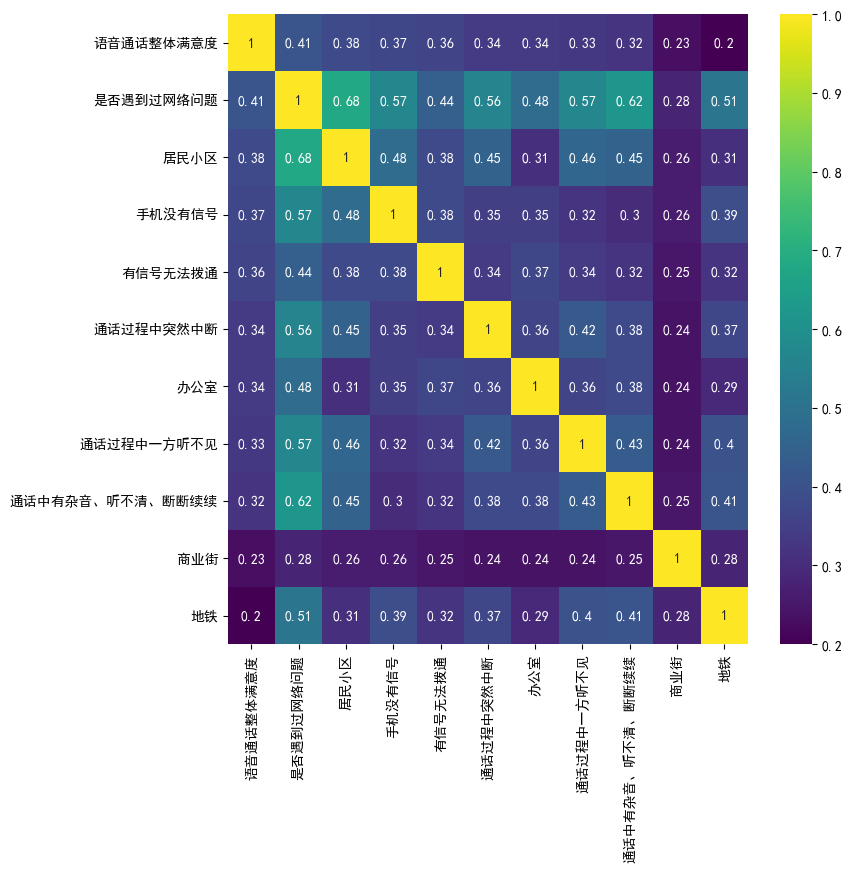

In [7]:
corr = train_data.corr().abs()
k = 11  #(cor>=0.2)
col = corr.nlargest(k, '语音通话整体满意度')['语音通话整体满意度'].index   
corr = corr.loc[col, col]
corr = corr.round(2)

plt.subplots(figsize=(10, 10))
plt.subplots_adjust(left=0.25, bottom=0.25)
sns.heatmap(corr, annot=True, fmt="g", cmap='viridis')
plt.savefig('./output/语音通话整体满意度相关性.png', dpi=300)
plt.show()

## 数据划分

In [8]:
x = train_data.loc[:, col].drop(['语音通话整体满意度'],axis=1)
x

,是否遇到过网络问题,居民小区,手机没有信号,有信号无法拨通,通话过程中突然中断,办公室,通话过程中一方听不见,通话中有杂音、听不清、断断续续,商业街,地铁
0,0,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,1,1,1,1,0
2,0,0,1,0,0,0,1,0,0,0
3,0,1,1,1,0,1,0,0,0,0
4,0,0,0,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
5428,0,0,0,0,1,1,1,0,0,0
5429,0,1,0,0,0,1,1,1,0,0
5430,0,0,1,1,0,0,0,0,1,0
5431,0,0,0,0,1,0,0,1,0,1


In [9]:
y = train_data["语音通话整体满意度"]
y

0       10
1        2
2       10
3        6
4        5
        ..
5428    10
5429    10
5430     6
5431     9
5432    10
Name: 语音通话整体满意度, Length: 5433, dtype: int64

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
 x_train

,是否遇到过网络问题,居民小区,手机没有信号,有信号无法拨通,通话过程中突然中断,办公室,通话过程中一方听不见,通话中有杂音、听不清、断断续续,商业街,地铁
5017,0,1,1,1,0,0,0,0,0,1
1612,1,0,0,0,0,0,0,0,0,0
2683,0,0,0,0,0,0,0,1,0,0
652,1,0,0,0,0,0,0,0,0,0
3229,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3772,0,1,1,1,1,1,1,1,0,1
5191,0,1,1,1,0,1,0,1,0,0
5226,1,0,0,0,0,0,0,0,0,0
5390,0,1,1,0,1,0,1,0,0,1


In [11]:
 x_val

,是否遇到过网络问题,居民小区,手机没有信号,有信号无法拨通,通话过程中突然中断,办公室,通话过程中一方听不见,通话中有杂音、听不清、断断续续,商业街,地铁
5256,0,1,1,0,0,1,1,0,0,0
4949,1,0,0,0,0,0,0,0,0,0
2146,1,0,0,0,0,0,0,0,0,0
501,0,1,1,0,0,1,0,0,0,0
4462,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4997,0,0,0,0,0,0,1,1,1,1
2458,0,1,1,1,1,1,1,1,1,1
3732,1,0,0,0,0,0,0,0,0,0
2406,1,0,0,0,0,0,0,0,0,0


## 模型训练

In [12]:
def eval(model):
    val_set = pd.DataFrame()
    
    start = time()
    pred = model.predict(x_val)
    end = time()        
    temp = pd.DataFrame(
            {   
                "Acc":("%0.3f" % (accuracy_score(y_val,pred))),
                "MAE":("%0.3f" % (mean_absolute_error(y_val,pred))),
                "MSE":("%0.3f" % (mean_squared_error(y_val,pred))),
                "Latency":("%0.1fms" % ((end-start)*1000))
            }, index=[(str(model).split("(")[0])]
    )
    val_set = pd.concat([val_set,temp])
    
    return val_set
        

In [13]:
rc = RidgeClassifier()
parameters = {
    "alpha":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    "normalize":[True,False]
}

rc_cv = GridSearchCV(rc, parameters, cv=5)
rc_cv.fit(x_train,y_train)
rc_cv.best_estimator_

RidgeClassifier(alpha=0.3, normalize=True)

In [14]:
rc_eval = eval(rc_cv.best_estimator_)
rc_eval

,Acc,MAE,MSE,Latency
RidgeClassifier,0.584,1.254,6.299,2.0ms


In [15]:
dt = DecisionTreeClassifier()
parameters = {
    "criterion":['gini', 'entropy','log_loss'],
    "max_depth":[2,4,8,16,32],
    "min_samples_leaf":[2,4,8,16,32],
    "min_samples_split":[2,4,8,16,32]
}

dt_cv = GridSearchCV(dt, parameters, cv=5)
dt_cv.fit(x_train,y_train)
dt_cv.best_estimator_

DecisionTreeClassifier(max_depth=2, min_samples_leaf=2)

In [16]:
dt_eval = eval(dt_cv.best_estimator_)
dt_eval

,Acc,MAE,MSE,Latency
DecisionTreeClassifier,0.581,1.320,6.991,1.0ms


In [17]:
rf = RandomForestClassifier()
parameters = {
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,25,50,250,500]
}

rf_cv = GridSearchCV(rf, parameters, cv=5)
rf_cv.fit(x_train,y_train)
rf_cv.best_estimator_

RandomForestClassifier(max_depth=4, n_estimators=250)

In [18]:
rf_eval = eval(rf_cv.best_estimator_)
rf_eval

,Acc,MAE,MSE,Latency
RandomForestClassifier,0.584,1.286,6.670,6.0ms


In [20]:
ada = AdaBoostClassifier()
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "n_estimators":[5,25,50,250,500]
}

ada_cv = GridSearchCV(ada, parameters, cv=5)
ada_cv.fit(x_train,y_train)
ada_cv.best_estimator_

AdaBoostClassifier(learning_rate=0.1)

In [22]:
ada_eval = eval(ada_cv.best_estimator_)
ada_eval

,Acc,MAE,MSE,Latency
AdaBoostClassifier,0.580,1.294,6.645,30.9ms


In [ ]:
gb = GradientBoostingClassifier()
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,25,50,250,500]
}

gb_cv = GridSearchCV(gb, parameters, cv=5)
gb_cv.fit(x_train,y_train)
gb_cv.best_estimator_

In [ ]:
gb_eval = eval(gb_cv.best_estimator_)
gb_eval

In [23]:
xgb = XGBClassifier()
parameters = {
    "n_estimators":[5,25,50,250,500],
    "max_depth":[2,4,8,16,32],
    "learning_rate":[0.01,0.1,1.0,10,100]
}

xgb_cv = GridSearchCV(xgb, parameters, cv=5)
xgb_cv.fit(x_train,y_train)
xgb_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
xgb_eval = eval(xgb_cv.best_estimator_)
xgb_eval

,Acc,MAE,MSE,Latency
XGBClassifier,0.583,1.277,6.546,45.6ms


In [25]:
svc = SVC()
parameters = {
    "C":[0.001,0.01,0.1,1.0,10,100,1000],
    "kernel":["linear","poly","rbf","sigmoid"]
}

svc_cv = GridSearchCV(svc, parameters, cv=5)
svc_cv.fit(x_train,y_train)
svc_cv.best_estimator_

SVC(C=0.01, kernel='poly')

In [26]:
svc_eval = eval(svc_cv.best_estimator_)
svc_eval

,Acc,MAE,MSE,Latency
SVC,0.584,1.284,6.631,43.5ms


In [28]:
mlp = MLPClassifier()
parameters = {
    "activation":["identity","logistic","tanh","relu"],
    "hidden_layer_sizes":[(10,),(50,),(100,)],
    "learning_rate":["constant","invscaling","adaptive"],
    "solver":["lbfgs","sgd","adam"]
}

mlp_cv = GridSearchCV(mlp, parameters, cv=5)
mlp_cv.fit(x_train, y_train)
mlp_cv.best_estimator_

MLPClassifier(solver='sgd')

In [29]:
mlp_eval = eval(mlp_cv.best_estimator_)
mlp_eval

,Acc,MAE,MSE,Latency
MLPClassifier,0.587,1.247,6.287,2.7ms


In [ ]:
estimators = [("rc",rc_cv.best_estimator_),
              ("dt",dt_cv.best_estimator_),
              ("rf",rf_cv.best_estimator_),
              ("ada",ada_cv.best_estimator_),
              ("gb",gb_cv.best_estimator_),
              ("xgb",xgb_cv.best_estimator_),
              ("svc",svc_cv.best_estimator_),
              ("mlp",mlp_cv.best_estimator_)]

sc = StackingClassifier(estimators=estimators)
parameters = {
    "passthrough":[True,False]
}

sc_cv = GridSearchCV(sr, parameters, cv=5)
sc_cv.fit(x_train,y_train)
sc_cv.best_estimator_

In [ ]:
models = [rc_cv.best_estimator_,
          dt_cv.best_estimator_,
          rf_cv.best_estimator_,
          ada_cv.best_estimator_,
          gb_cv.best_estimator_,
          xgb_cv.best_estimator_,
          svc_cv.best_estimator_,
          mlp_cv.best_estimator_,
          sc_cv.best_estimator_]

In [ ]:
val_set = pd.DataFrame()
    
for i in models:
        start = time()
        pred = i.predict(x_val)
        end = time()        
        temp = pd.DataFrame(
                {   
                    "Acc":("%0.3f" % (accuracy_score(y_val,pred))),
                    "MAE":("%0.3f" % (mean_absolute_error(y_val,pred))),
                    "MSE":("%0.3f" % (mean_squared_error(y_val,pred))),
                    "Latency":("%0.1fms" % ((end-start)*1000))
                }, index=[(str(i).split("(")[0])]
        val_set = pd.concat([val_set,temp])
val_set

## 预测

In [ ]:
test = pd.read_excel("./output/语音测试集.xlsx")

In [ ]:
test_data = pd.DataFrame.copy(test, deep=True)
test_data

In [ ]:
test_col = col.drop('语音通话整体满意度')

In [ ]:
test_data = test_data.loc[:, test_col]
test_data

In [ ]:
y_pred_test = mlp_cv.best_estimator_.predict(test_data)

In [ ]:
output = pd.DataFrame({'用户id': test['用户id'], '语音通话整体满意度': np.round(y_pred_test, 0)})
output

In [ ]:
output.to_excel('./output//result-语音通话整体满意度.xlsx', index=False)